# Testing the Iterative Ensemble Algorithms and Producing Metrics of Performance

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import copy 
import os
os.environ["PROJ_LIB"] = "C:\\ProgramData\\Anaconda3\\Library\\share";
from mpl_toolkits.basemap import Basemap
from scipy import interpolate
from scipy import optimize
import random
import numpy as np
from scipy.interpolate import Akima1DInterpolator
from sklearn import datasets, linear_model
import pickle
import matplotlib

levels = [0, 1, 2, 3, 4, 5]
colors = ['black', 'green', 'brown', 'yellow', 'blue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
    
plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Individual algorithm simulations

In [2]:
# load test ensemble data
with open('test_data/2018_ensTest_48hrs.pickle', 'rb') as handle:
    ensemble_data = pickle.load(handle)
with open('test_data/2018_meanEnsTest_48hrs.pickle', 'rb') as handle:
    meanEnsTest_data = pickle.load(handle)
with open('test_data/2018_bestLabelTest_48hrs.pickle', 'rb') as handle:
    bestLabelTest_data = pickle.load(handle)

# initialization
ens_tn = ['AC00', 'AP01','AP02','AP03','AP04','AP05','AP06','AP07','AP08','AP09','AP10','AP11','AP12','AP13','AP14',
          'AP15','AP16','AP17','AP18','AP19','AP20']
ens_mean_tn = ['AEMN'] # ensemble mean track name
best_tn = ['BEST']

#forecast_periods = [0, 6, 12, 18, 24] # forecast horizon is 24hrs, and time step is 6 hrs, origin is from 6hrs
forecast_periods = [0, 6, 12, 18, 24, 30, 36, 42, 48] 

nens = len(ens_tn)
ntst = len(forecast_periods) # number of time steps. 6hrs is the time step for the GEFS forecasts.

In [3]:
%run egctf_main.ipynb


senFPr = 50e3 # sensor footprint radius in [m]

phase2_lastKnown_thresh = 48*60/60 # last time storm is seen in hours
timeSinceLastKnown = np.inf


wetp = 1 # confidence in ensemble velocity 

#obs_times = np.array([0.806944444444445,0.815555555555556,0.824166666666667,0.832777777777778,0.841388888888889,1.01055555555556,1.01916666666667,1.02777777777778,1.03638888888889,1.04500000000000,1.05361111111111,1.06222222222222,1.21555555555556,1.22416666666667,1.23277777777778,1.24138888888889,1.25000000000000,1.25861111111111,1.26722222222222,1.27583333333333,1.42194444444444,1.43055555555556,1.43916666666667,1.44777777777778,1.45638888888889,1.46500000000000,1.47361111111111,1.48222222222222,1.49083333333333,1.49944444444444,1.63138888888889,1.64000000000000,1.64861111111111,1.65722222222222,1.66583333333333,1.67444444444444,1.68305555555556,1.69166666666667,1.70027777777778,1.70888888888889,1.84083333333333,1.84944444444444,1.85805555555556,1.86666666666667,1.87527777777778,1.88388888888889,1.89250000000000,1.90111111111111,1.90972222222222,1.91833333333333,1.92694444444444,2.05000000000000,2.05861111111111,2.06722222222222,2.07583333333333,2.08444444444444,2.09305555555556,2.10166666666667,2.11027777777778,2.11888888888889,2.12750000000000,2.13611111111111,2.26000000000000,2.26861111111111,2.27722222222222,2.28583333333333,2.29444444444444,2.30305555555556,2.31166666666667,2.32027777777778,2.32888888888889,2.33750000000000,2.34611111111111,2.47166666666667,2.48027777777778,2.48888888888889,2.49750000000000,2.50611111111111,2.51472222222222,2.52333333333333,2.53194444444444,2.54055555555556,2.54916666666667,2.55777777777778,2.68361111111111,2.69222222222222,2.70083333333333,2.70944444444444,2.71805555555556,2.72666666666667,2.73527777777778,2.74388888888889,2.75250000000000,2.76111111111111,2.76972222222222,2.89388888888889,2.90250000000000,2.91111111111111,2.91972222222222,2.92833333333333,2.93694444444444,2.94555555555556,2.95416666666667,2.96277777777778,2.97138888888889,2.98000000000000,3.10666666666667,3.11527777777778,3.12388888888889,3.13250000000000,3.14111111111111,3.14972222222222,3.15833333333333,3.16694444444444,3.17555555555556,3.18416666666667,3.32500000000000,3.33361111111111,3.34222222222222,3.35083333333333,3.35944444444444,3.36805555555556,3.37666666666667,3.38527777777778,3.39388888888889,3.54444444444444,3.55305555555556,3.56166666666667,3.57027777777778,3.57888888888889,3.58750000000000,3.59611111111111,3.77000000000000,3.77861111111111,3.78722222222222,8.59250000000000,8.60111111111111,8.60972222222222,8.61833333333333,8.78527777777778,8.79388888888889,8.80250000000000,8.81111111111111,8.81972222222222,8.82833333333333,8.83694444444445,8.99138888888889,9,9.00861111111111,9.01722222222222,9.02583333333333,9.03444444444444,9.04305555555556,9.05166666666667,9.06027777777778,9.20138888888889,9.21000000000000,9.21861111111111,9.22722222222222,9.23583333333333,9.24444444444444,9.25305555555556,9.26166666666667,9.27027777777778,9.27888888888889,9.40361111111111,9.41222222222222,9.42083333333333,9.42944444444444,9.43805555555556,9.44666666666667,9.45527777777778,9.46388888888889,9.47250000000000,9.48111111111111,9.48972222222222,9.60805555555556,9.61666666666667,9.62527777777778,9.63388888888889,9.64250000000000,9.65111111111111,9.65972222222222,9.66833333333333,9.67694444444445,9.68555555555556,9.69416666666667,9.82333333333333,9.83194444444444,9.84055555555556,9.84916666666667,9.85777777777778,9.86638888888889,9.87500000000000,9.88361111111111,9.89222222222222,9.90083333333333,9.90944444444444,10.0400000000000,10.0486111111111,10.0572222222222,10.0658333333333,10.0744444444444,10.0830555555556,10.0916666666667,10.1002777777778,10.1088888888889,10.1175000000000,10.1261111111111,10.2472222222222,10.2558333333333,10.2644444444444,10.2730555555556,10.2816666666667,10.2902777777778,10.2988888888889,10.3075000000000,10.3161111111111,10.3247222222222,10.3333333333333,10.4541666666667,10.4627777777778,10.4713888888889,10.4800000000000,10.4886111111111,10.4972222222222,10.5058333333333,10.5144444444444,10.5230555555556,10.5316666666667,10.5402777777778,10.6725000000000,10.6811111111111,10.6897222222222,10.6983333333333,10.7069444444444,10.7155555555556,10.7241666666667,10.7327777777778,10.7413888888889,10.7500000000000,10.8930555555556,10.9016666666667,10.9102777777778,10.9188888888889,10.9275000000000,10.9361111111111,10.9447222222222,10.9533333333333,10.9619444444444,11.1027777777778,11.1113888888889,11.1200000000000,11.1286111111111,11.1372222222222,11.1458333333333,11.1544444444444,11.1630555555556,11.1716666666667,11.3150000000000,11.3236111111111,11.3322222222222,11.3408333333333,11.3494444444444,11.3580555555556,11.3666666666667,11.5416666666667,11.5502777777778,11.5588888888889,11.5675000000000,11.5761111111111,12.5011111111111,12.5097222222222,12.5183333333333,12.5269444444444,12.6888888888889,12.6975000000000,12.7061111111111,12.7147222222222,12.7233333333333,12.7319444444444,12.7405555555556,12.8955555555556,12.9041666666667,12.9127777777778,12.9213888888889,12.9300000000000,12.9386111111111,12.9472222222222,12.9558333333333,12.9644444444444,13.1111111111111,13.1197222222222,13.1283333333333,13.1369444444444,13.1455555555556,13.1541666666667,13.1627777777778,13.1713888888889,13.1800000000000,13.1886111111111,13.3161111111111,13.3247222222222,13.3333333333333,13.3419444444444,13.3505555555556,13.3591666666667,13.3677777777778,13.3763888888889,13.3850000000000,13.3936111111111,13.4022222222222,13.5158333333333,13.5244444444444,13.5330555555556,13.5416666666667,13.5502777777778,13.5588888888889,13.5675000000000,13.5761111111111,13.5847222222222,13.5933333333333,13.6019444444444,13.7272222222222,13.7358333333333,13.7444444444444,13.7530555555556,13.7616666666667,13.7702777777778,13.7788888888889,13.7875000000000,13.7961111111111,13.8047222222222,13.8133333333333,13.9480555555556,13.9566666666667,13.9652777777778,13.9738888888889,13.9825000000000,13.9911111111111,13.9997222222222,14.0083333333333,14.0169444444444,14.0255555555556,14.0341666666667,14.1569444444444,14.1655555555556,14.1741666666667,14.1827777777778,14.1913888888889,14.2000000000000,14.2086111111111,14.2172222222222,14.2258333333333,14.2344444444444,14.2430555555556,14.3586111111111,14.3672222222222,14.3758333333333,14.3844444444444,14.3930555555556,14.4016666666667,14.4102777777778,14.4188888888889,14.4275000000000,14.4361111111111,14.4447222222222,14.5763888888889,14.5850000000000,14.5936111111111,14.6022222222222,14.6108333333333,14.6194444444444,14.6280555555556,14.6366666666667,14.6452777777778,14.6538888888889,14.8025000000000,14.8111111111111,14.8197222222222,14.8283333333333,14.8369444444444,14.8455555555556,14.8541666666667,14.8627777777778,14.8713888888889,15.0161111111111,15.0247222222222,15.0333333333333,15.0419444444444,15.0505555555556,15.0591666666667,15.0677777777778,15.0763888888889,15.2225000000000,15.2311111111111,15.2397222222222,15.2483333333333,15.2569444444444,15.2655555555556,15.2741666666667,15.4438888888889,15.4525000000000,15.4611111111111,15.4697222222222,15.4783333333333,15.6808333333333,15.6894444444444,16.4152777777778,16.4238888888889,16.4325000000000,16.4411111111111,16.4497222222222,16.4583333333333,16.6013888888889,16.6100000000000,16.6186111111111,16.6272222222222,16.6358333333333,16.6444444444444,16.6530555555556,16.6616666666667,16.6702777777778,16.6788888888889,16.6875000000000,16.8000000000000,16.8086111111111,16.8172222222222,16.8258333333333,16.8344444444444,16.8430555555556,16.8516666666667,16.8602777777778,16.8688888888889,16.8775000000000,16.8861111111111,16.8947222222222,16.9033333333333,16.9119444444444,16.9205555555556,17.0166666666667,17.0252777777778,17.0338888888889,17.0425000000000,17.0511111111111,17.0597222222222,17.0683333333333,17.0769444444444,17.0855555555556,17.0941666666667,17.1027777777778,17.1113888888889,17.1200000000000,17.1286111111111,17.2275000000000,17.2361111111111,17.2447222222222,17.2533333333333,17.2619444444444,17.2705555555556,17.2791666666667,17.2877777777778,17.2963888888889,17.3050000000000,17.3136111111111,17.3222222222222,17.3308333333333,17.4230555555556,17.4316666666667,17.4402777777778,17.4488888888889,17.4575000000000,17.4661111111111,17.4747222222222,17.4833333333333,17.4919444444444,17.5005555555556,17.5091666666667,17.5177777777778,17.5263888888889,17.5350000000000,17.5436111111111,17.5522222222222,17.6294444444444,17.6380555555556,17.6466666666667,17.6552777777778,17.6638888888889,17.6725000000000,17.6811111111111,17.6897222222222,17.6983333333333,17.7069444444444,17.7155555555556,17.7241666666667,17.7327777777778,17.7413888888889,17.7500000000000,17.7586111111111,17.7672222222222,17.7758333333333,17.8538888888889,17.8625000000000,17.8711111111111,17.8797222222222,17.8883333333333,17.8969444444444,17.9055555555556,17.9141666666667,17.9227777777778,17.9313888888889,17.9400000000000,17.9486111111111,17.9572222222222,17.9658333333333,17.9744444444444,17.9830555555556,18.0702777777778,18.0788888888889,18.0875000000000,18.0961111111111,18.1047222222222,18.1133333333333,18.1219444444444,18.1305555555556,18.1391666666667,18.1477777777778,18.1563888888889,18.1650000000000,18.1736111111111,18.1822222222222,18.2700000000000,18.2786111111111,18.2872222222222,18.2958333333333,18.3044444444444,18.3130555555556,18.3216666666667,18.3302777777778,18.3388888888889,18.3475000000000,18.3561111111111,18.3647222222222,18.3733333333333,18.3819444444444,18.3905555555556,18.3991666666667,18.4788888888889,18.4875000000000,18.4961111111111,18.5047222222222,18.5133333333333,18.5219444444444,18.5305555555556,18.5391666666667,18.5477777777778,18.5563888888889,18.5650000000000,18.5736111111111,18.5822222222222,18.5908333333333,18.5994444444444,18.6080555555556,18.6166666666667,18.7069444444444,18.7155555555556,18.7241666666667,18.7327777777778,18.7413888888889,18.7500000000000,18.7586111111111,18.7672222222222,18.7758333333333,18.7844444444444,18.7930555555556,18.8016666666667,18.8102777777778,18.8188888888889,18.9269444444444,18.9355555555556,18.9441666666667,18.9527777777778,18.9613888888889,18.9700000000000,18.9786111111111,18.9872222222222,18.9958333333333,19.0044444444444,19.0130555555556,19.1294444444444,19.1380555555556,19.1466666666667,19.1552777777778,19.1638888888889,19.1725000000000,19.1811111111111,19.1897222222222,19.1983333333333,19.2069444444444,19.2155555555556,19.2241666666667,19.3450000000000,19.3536111111111,19.3622222222222,19.3708333333333,19.3794444444444,19.3880555555556,19.4036111111111,19.4122222222222,19.4208333333333,19.4294444444444,19.4380555555556,19.5888888888889,19.5975000000000,20.3355555555556,20.3441666666667,20.3527777777778,20.3613888888889,20.3700000000000,20.5422222222222,20.5508333333333,20.5594444444444,20.5680555555556,20.5766666666667,20.5852777777778,20.5938888888889,20.7636111111111,20.7722222222222,20.7808333333333,20.7894444444444,20.7980555555556,20.8066666666667,20.8152777777778,20.8238888888889,20.9669444444444,20.9755555555556,20.9841666666667,20.9927777777778,21.0013888888889,21.0100000000000,21.0186111111111,21.0272222222222,21.0358333333333,21.1597222222222,21.1683333333333,21.1769444444444,21.1855555555556,21.1941666666667,21.2027777777778,21.2113888888889,21.2200000000000,21.2286111111111,21.2372222222222,21.3730555555556,21.3816666666667,21.3902777777778,21.3988888888889,21.4075000000000,21.4161111111111,21.4247222222222,21.4333333333333,21.4419444444444,21.4505555555556,21.5975000000000,21.6061111111111,21.6147222222222,21.6233333333333,21.6319444444444,21.6405555555556,21.6491666666667,21.6577777777778,21.6663888888889,21.6750000000000,21.6836111111111,21.8027777777778,21.8113888888889,21.8200000000000,21.8286111111111,21.8372222222222,21.8458333333333,21.8544444444444,21.8630555555556,21.8716666666667,21.8802777777778,21.8888888888889,21.9969444444444,22.0055555555556,22.0141666666667,22.0227777777778,22.0313888888889,22.0400000000000,22.0486111111111,22.0572222222222,22.0658333333333,22.0744444444444,22.0830555555556,22.2127777777778,22.2213888888889,22.2300000000000,22.2386111111111,22.2472222222222,22.2558333333333,22.2644444444444,22.2730555555556,22.2816666666667,22.2902777777778,22.2988888888889,22.4425000000000,22.4511111111111,22.4597222222222,22.4683333333333,22.4769444444444,22.4855555555556,22.4941666666667,22.5027777777778,22.5113888888889,22.5200000000000,22.5286111111111,22.6516666666667,22.6602777777778,22.6688888888889,22.6775000000000,22.6861111111111,22.6947222222222,22.7033333333333,22.7119444444444,22.7205555555556,22.7291666666667,22.8500000000000,22.8586111111111,22.8672222222222,22.8758333333333,22.8844444444444,22.8930555555556,22.9016666666667,22.9102777777778,22.9188888888889,23.0722222222222,23.0808333333333,23.0894444444444,23.0980555555556,23.1066666666667,23.1152777777778,23.1238888888889,23.3116666666667,23.3202777777778,23.3288888888889,23.3375000000000,23.3461111111111])
#obs_times = np.array([0.806944444444445,1.01055555555556,1.21555555555556,1.42194444444444,1.63138888888889,1.71500000000000,1.84083333333333,1.92444444444444,2.05000000000000,2.13361111111111,2.26000000000000,2.34361111111111,2.47166666666667,2.55527777777778,2.68361111111111,2.76722222222222,2.89388888888889,2.97750000000000,3.10666666666667,3.32500000000000,3.54444444444444,3.77000000000000,8.59250000000000,8.78527777777778,8.99138888888889,9.20138888888889,9.40361111111111,9.48722222222222,9.60805555555556,9.69166666666667,9.82333333333333,9.90694444444445,10.0400000000000,10.1236111111111,10.2472222222222,10.3308333333333,10.4541666666667,10.5377777777778,10.6725000000000,10.8930555555556,11.1027777777778,11.3150000000000,11.5416666666667,12.5011111111111,12.6888888888889,12.8955555555556,13.1111111111111,13.3161111111111,13.3997222222222,13.5158333333333,13.5994444444444,13.7272222222222,13.8108333333333,13.9480555555556,14.0316666666667,14.1569444444444,14.2405555555556,14.3586111111111,14.4422222222222,14.5763888888889,14.6600000000000,14.8025000000000,15.0161111111111,15.2225000000000,15.4438888888889,15.6808333333333,16.4152777777778,16.6013888888889,16.6850000000000,16.8000000000000,16.8836111111111,17.0166666666667,17.1002777777778,17.2275000000000,17.3111111111111,17.4230555555556,17.5066666666667,17.6294444444444,17.7130555555556,17.8538888888889,17.9375000000000,18.0702777777778,18.1538888888889,18.2700000000000,18.3536111111111,18.4788888888889,18.5625000000000,18.7069444444444,18.7905555555556,18.9269444444444,19.0105555555556,19.1294444444444,19.2130555555556,19.3450000000000,19.4286111111111,19.5888888888889,20.3355555555556,20.5422222222222,20.7636111111111,20.9669444444444,21.1597222222222,21.3730555555556,21.4566666666667,21.5975000000000,21.6811111111111,21.8027777777778,21.8863888888889,21.9969444444444,22.0805555555556,22.2127777777778,22.2963888888889,22.4425000000000,22.5261111111111,22.6516666666667,22.7352777777778,22.8500000000000,23.0722222222222,23.3116666666667])
#obs_times = np.array([0.806944444444445,0.815555555555556,0.824166666666667,0.832777777777778,0.841388888888889,1.01055555555556,1.01916666666667,1.02777777777778,1.03638888888889,1.04500000000000,1.05361111111111,1.06222222222222,1.21555555555556,1.22416666666667,1.23277777777778,1.24138888888889,1.25000000000000,1.25861111111111,1.26722222222222,1.27583333333333,1.42194444444444,1.43055555555556,1.43916666666667,1.44777777777778,1.45638888888889,1.46500000000000,1.47361111111111,1.48222222222222,1.49083333333333,1.49944444444444,1.63138888888889,1.64000000000000,1.64861111111111,1.65722222222222,1.66583333333333,1.67444444444444,1.68305555555556,1.69166666666667,1.70027777777778,1.70888888888889,1.84083333333333,1.84944444444444,1.85805555555556,1.86666666666667,1.87527777777778,1.88388888888889,1.89250000000000,1.90111111111111,1.90972222222222,1.91833333333333,1.92694444444444,2.05000000000000,2.05861111111111,2.06722222222222,2.07583333333333,2.08444444444444,2.09305555555556,2.10166666666667,2.11027777777778,2.11888888888889,2.12750000000000,2.13611111111111,2.26000000000000,2.26861111111111,2.27722222222222,2.28583333333333,2.29444444444444,2.30305555555556,2.31166666666667,2.32027777777778,2.32888888888889,2.33750000000000,2.34611111111111,2.47166666666667,2.48027777777778,2.48888888888889,2.49750000000000,2.50611111111111,2.51472222222222,2.52333333333333,2.53194444444444,2.54055555555556,2.54916666666667,2.55777777777778,2.68361111111111,2.69222222222222,2.70083333333333,2.70944444444444,2.71805555555556,2.72666666666667,2.73527777777778,2.74388888888889,2.75250000000000,2.76111111111111,2.76972222222222,2.89388888888889,2.90250000000000,2.91111111111111,2.91972222222222,2.92833333333333,2.93694444444444,2.94555555555556,2.95416666666667,2.96277777777778,2.97138888888889,2.98000000000000,3.10666666666667,3.11527777777778,3.12388888888889,3.13250000000000,3.14111111111111,3.14972222222222,3.15833333333333,3.16694444444444,3.17555555555556,3.18416666666667,3.32500000000000,3.33361111111111,3.34222222222222,3.35083333333333,3.35944444444444,3.36805555555556,3.37666666666667,3.38527777777778, 3.39388888888889,3.54444444444444,3.55305555555556,3.56166666666667,3.57027777777778,3.57888888888889,3.58750000000000, 3.59611111111111,3.77000000000000,3.77861111111111,3.78722222222222,8.59250000000000,8.60111111111111,8.60972222222222,8.61833333333333,8.78527777777778,8.79388888888889,8.80250000000000,8.81111111111111,8.81972222222222,8.82833333333333,8.83694444444445,8.99138888888889,9,9.00861111111111,9.01722222222222,9.02583333333333,9.03444444444444,9.04305555555556, 9.05166666666667,9.06027777777778,9.20138888888889,9.21000000000000,9.21861111111111,9.22722222222222,9.23583333333333,9.24444444444444,9.25305555555556,9.26166666666667,9.27027777777778,9.27888888888889,9.40361111111111,9.41222222222222, 9.42083333333333,9.42944444444444,9.43805555555556,9.44666666666667,9.45527777777778,9.46388888888889,9.47250000000000,9.48111111111111,9.48972222222222,9.60805555555556,9.61666666666667,9.62527777777778,9.63388888888889,9.64250000000000,9.65111111111111,9.65972222222222,9.66833333333333,9.67694444444445,9.68555555555556,9.69416666666667,9.82333333333333,9.83194444444444,9.84055555555556,9.84916666666667,9.85777777777778,9.86638888888889,9.87500000000000,9.88361111111111,9.89222222222222,9.90083333333333,9.90944444444444,10.0400000000000,10.0486111111111,10.0572222222222,10.0658333333333,10.0744444444444,10.0830555555556,10.0916666666667,10.1002777777778,10.1088888888889,10.1175000000000,10.1261111111111,10.2472222222222,10.2558333333333,10.2644444444444,10.2730555555556,10.2816666666667,10.2902777777778,10.2988888888889,10.3075000000000,10.3161111111111,10.3247222222222,10.3333333333333,10.4541666666667,10.4627777777778,10.4713888888889,10.4800000000000,10.4886111111111,10.4972222222222,10.5058333333333,10.5144444444444,10.5230555555556,10.5316666666667,10.5402777777778,10.6725000000000,10.6811111111111,10.6897222222222,10.6983333333333,10.7069444444444,10.7155555555556,10.7241666666667,10.7327777777778,10.7413888888889,10.7500000000000,10.8930555555556,10.9016666666667,10.9102777777778,10.9188888888889,10.9275000000000,10.9361111111111,10.9447222222222,10.9533333333333,10.9619444444444,11.1027777777778,11.1113888888889,11.1200000000000,11.1286111111111,11.1372222222222,11.1458333333333,11.1544444444444,11.1630555555556,11.1716666666667,11.3150000000000,11.3236111111111,11.3322222222222,11.3408333333333,11.3494444444444,11.3580555555556,11.3666666666667,11.5416666666667,11.5502777777778,11.5588888888889,11.5675000000000,11.5761111111111,12.5011111111111,12.5097222222222,12.5183333333333,12.5269444444444,12.6888888888889,12.6975000000000,12.7061111111111,12.7147222222222,12.7233333333333,12.7319444444444,12.7405555555556,12.8955555555556,12.9041666666667,12.9127777777778,12.9213888888889,12.9300000000000,12.9386111111111,12.9472222222222,12.9558333333333,12.9644444444444,13.1111111111111,13.1197222222222,13.1283333333333,13.1369444444444,13.1455555555556,13.1541666666667,13.1627777777778,13.1713888888889,13.1800000000000,13.1886111111111,13.3161111111111,13.3247222222222,13.3333333333333,13.3419444444444,13.3505555555556,13.3591666666667,13.3677777777778,13.3763888888889,13.3850000000000,13.3936111111111,13.4022222222222,13.5158333333333,13.5244444444444,13.5330555555556,13.5416666666667,13.5502777777778,13.5588888888889,13.5675000000000,13.5761111111111,13.5847222222222,13.5933333333333,13.6019444444444,13.7272222222222,13.7358333333333,13.7444444444444,13.7530555555556,13.7616666666667,13.7702777777778,13.7788888888889,13.7875000000000,13.7961111111111,13.8047222222222,13.8133333333333,13.9480555555556,13.9566666666667,13.9652777777778,13.9738888888889,13.9825000000000,13.9911111111111,13.9997222222222,14.0083333333333,14.0169444444444,14.0255555555556,14.0341666666667,14.1569444444444,14.1655555555556,14.1741666666667,14.1827777777778,14.1913888888889,14.2000000000000,14.2086111111111,14.2172222222222,14.2258333333333,14.2344444444444,14.2430555555556,14.3586111111111,14.3672222222222,14.3758333333333,14.3844444444444,14.3930555555556,14.4016666666667,14.4102777777778,14.4188888888889,14.4275000000000,14.4361111111111,14.4447222222222,14.5763888888889,14.5850000000000,14.5936111111111,14.6022222222222,14.6108333333333,14.6194444444444,14.6280555555556,14.6366666666667,14.6452777777778,14.6538888888889,14.8025000000000,14.8111111111111,14.8197222222222,14.8283333333333,14.8369444444444,14.8455555555556,14.8541666666667,14.8627777777778,14.8713888888889,15.0161111111111,15.0247222222222,15.0333333333333,15.0419444444444,15.0505555555556,15.0591666666667,15.0677777777778,15.0763888888889,15.2225000000000,15.2311111111111,15.2397222222222,15.2483333333333,15.2569444444444,15.2655555555556,15.2741666666667,15.4438888888889,15.4525000000000,15.4611111111111,15.4697222222222,15.4783333333333,15.6808333333333,15.6894444444444,16.4152777777778,16.4238888888889,16.4325000000000,16.4411111111111,16.4497222222222,16.4583333333333,16.6013888888889,16.6100000000000,16.6186111111111,16.6272222222222,16.6358333333333,16.6444444444444,16.6530555555556,16.6616666666667,16.6702777777778,16.6788888888889,16.6875000000000,16.8000000000000,16.8086111111111,16.8172222222222,16.8258333333333,16.8344444444444,16.8430555555556,16.8516666666667,16.8602777777778,16.8688888888889,16.8775000000000,16.8861111111111,16.8947222222222,16.9033333333333,16.9119444444444,16.9205555555556,17.0166666666667,17.0252777777778,17.0338888888889,17.0425000000000,17.0511111111111,17.0597222222222,17.0683333333333,17.0769444444444,17.0855555555556,17.0941666666667,17.1027777777778,17.1113888888889,17.1200000000000,17.1286111111111,17.2275000000000,17.2361111111111,17.2447222222222,17.2533333333333,17.2619444444444,17.2705555555556,17.2791666666667,17.2877777777778,17.2963888888889,17.3050000000000,17.3136111111111,17.3222222222222,17.3308333333333,17.4230555555556,17.4316666666667,17.4402777777778,17.4488888888889,17.4575000000000,17.4661111111111,17.4747222222222,17.4833333333333,17.4919444444444,17.5005555555556,17.5091666666667,17.5177777777778,17.5263888888889,17.5350000000000,17.5436111111111,17.5522222222222,17.6294444444444,17.6380555555556,17.6466666666667,17.6552777777778,17.6638888888889,17.6725000000000,17.6811111111111,17.6897222222222,17.6983333333333,17.7069444444444,17.7155555555556,17.7241666666667,17.7327777777778,17.7413888888889,17.7500000000000,17.7586111111111,17.7672222222222,17.7758333333333,17.8538888888889,17.8625000000000,17.8711111111111,17.8797222222222,17.8883333333333,17.8969444444444,17.9055555555556,17.9141666666667,17.9227777777778,17.9313888888889,17.9400000000000,17.9486111111111,17.9572222222222,17.9658333333333,17.9744444444444,17.9830555555556,18.0702777777778,18.0788888888889,18.0875000000000,18.0961111111111,18.1047222222222,18.1133333333333,18.1219444444444,18.1305555555556,18.1391666666667,18.1477777777778,18.1563888888889,18.1650000000000,18.1736111111111,18.1822222222222,18.2700000000000,18.2786111111111,18.2872222222222,18.2958333333333,18.3044444444444,18.3130555555556,18.3216666666667,18.3302777777778,18.3388888888889,18.3475000000000,18.3561111111111,18.3647222222222,18.3733333333333,18.3819444444444,18.3905555555556,18.3991666666667,18.4788888888889,18.4875000000000,18.4961111111111,18.5047222222222,18.5133333333333,18.5219444444444,18.5305555555556,18.5391666666667,18.5477777777778,18.5563888888889,18.5650000000000,18.5736111111111,18.5822222222222,18.5908333333333,18.5994444444444,18.6080555555556,18.6166666666667,18.7069444444444,18.7155555555556,18.7241666666667,18.7327777777778,18.7413888888889,18.7500000000000,18.7586111111111,18.7672222222222,18.7758333333333,18.7844444444444,18.7930555555556,18.8016666666667,18.8102777777778,18.8188888888889,18.9269444444444,18.9355555555556,18.9441666666667,18.9527777777778,18.9613888888889,18.9700000000000,18.9786111111111,18.9872222222222,18.9958333333333,19.0044444444444,19.0130555555556,19.1294444444444,19.1380555555556,19.1466666666667,19.1552777777778,19.1638888888889])
obs_times = min(forecast_periods) + np.linspace(0.5, max(forecast_periods), (max(forecast_periods) - min(forecast_periods))*5)

# original
#_ncov = np.array([0.5**2, 1**2, 2.5**2, 5**2, 7.5**2, 10**2, 12.5**2, 15**2, 17.5**2, 20**2, 22.5**2, 25**2, 27.5**2, 30**2])
#_ssglen = 1/60 * np.array([30, 37.5, 45, 52.5, 60, 67.5, 75, 82.5, 90, 97.5, 105, 112.5, 120, 127.5, 135, 142.5, 
#                           150, 157.5, 165, 172.5, 180])

# _2
_ncov = np.array([0.5**2, 1**2, 2.5**2, 5**2, 7.5**2, 10**2, 12.5**2, 15**2, 17.5**2, 20**2, 22.5**2, 25**2, 27.5**2, 30**2])
_ssglen = 1/60 * np.array([30,  60, 90,  120, 150, 180, 210, 240, 270, 300])

NCOV, SSGLEN = np.meshgrid(_ncov, _ssglen)

In [4]:
ex = 4

#ERROR = np.full(NCOV.shape, np.nan)
ALLRES = []

for j in range(0,NCOV.shape[0]):
    for k in range(0,NCOV.shape[1]):
        
        print('Case: ', NCOV[j,k], SSGLEN[j,k])
        
        regr_subseg_length_hrs = SSGLEN[j,k]
        #regr_seg_gap_hrs = 1
        regr_seg_gap_hrs = regr_subseg_length_hrs # ISSUE: Not sure of behaviour if these two are not equal
        obsErr = NCOV[j,k]*707.106781186548**2 # [m^2] (variance from actul position) the observation error must be less than the senFRr! 

        ex_derr_aemn = []
        ex_derr_algo = []

        ex_num_seen_aemn = []
        ex_num_seen_algo = []

        ensTracks = ensemble_data[ex]
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = ensTracks.reshape(nens, ntst, 4)

        bestTrack = bestLabelTest_data[ex]
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = bestTrack.reshape( ntst, 4)

        aemnTrack = meanEnsTest_data[ex]
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = aemnTrack.reshape(ntst, 4)

        algo_results = algo(ensTracks, bestTrack, aemnTrack, obs_times, senFPr, obsErr, forecast_periods, nens,
                            phase2_lastKnown_thresh, regr_seg_gap_hrs, regr_subseg_length_hrs, wetp)        
        
        ALLRES.append(algo_results)
        #ERROR[j,k] = algo_results['error_wna']
        
ALLRES = np.array(ALLRES)
ALLRES = ALLRES.reshape(NCOV.shape[0], NCOV.shape[1])
       
with open('test_noise_vs_subseglen_ex'+str(ex)+'.pickle', 'wb') as handle:
            pickle.dump(ALLRES, handle, protocol=pickle.HIGHEST_PROTOCOL)  
        
fig, ax = plt.subplots()
CS = ax.contourf(np.sqrt(NCOV), SSGLEN*60, ERROR)
ax.clabel(CS, fontsize=14, inline=1, colors= 'k', fmt='%1.1f')
ax.set_xlabel('Noise Standard Deviation [km]', fontsize=14)
ax.set_ylabel('Sub-segment length [min]', fontsize=14)


Case:  0.25 0.5
Case:  1.0 0.5
Case:  6.25 0.5
Case:  25.0 0.5
Case:  56.25 0.5
Case:  100.0 0.5
Case:  156.25 0.5
Case:  225.0 0.5
Case:  306.25 0.5
Case:  400.0 0.5
Case:  506.25 0.5
Case:  625.0 0.5
Case:  756.25 0.5
Case:  900.0 0.5


KeyboardInterrupt: 

## Visualize results

In [4]:

_ncov = np.array([0.5**2, 1**2, 2.5**2, 5**2, 7.5**2, 10**2, 12.5**2, 15**2, 17.5**2, 20**2, 22.5**2, 25**2, 27.5**2, 30**2])
_ssglen = 1/60 * np.array([30,  60, 90,  120, 150, 180, 210, 240, 270, 300])

NCOV, SSGLEN = np.meshgrid(_ncov, _ssglen)

ex = 4
bestTrack = bestLabelTest_data[ex]
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = bestTrack.reshape( ntst, 4)

bt_x = list(bestTrack[:,2]) # get best-track info for the kth dataset
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods


In [5]:
with open('test_noise_vs_subseglen_ex4.pickle', 'rb') as handle:
    ALLRES = pickle.load(handle)

ERROR = np.full(NCOV.shape, np.nan)
KSPVARX = np.full(NCOV.shape, np.nan)
KSPVARY = np.full(NCOV.shape, np.nan)

for j in range(0, ALLRES.shape[0]):
    for k in range(0, ALLRES.shape[1]):
        ERROR[j,k] = ALLRES[j,k]['error_wna']
        obsti = ALLRES[j,k]['known_storm_position'][:,2]
        bt_pos_ksp = storm_position_akima(bt_x, bt_y, bt_t, obsti)
        KSPVARX[j,k] = np.var(ALLRES[j,k]['known_storm_position'][:,0] - bt_pos_ksp[0])
        KSPVARY[j,k] = np.var(ALLRES[j,k]['known_storm_position'][:,1] - bt_pos_ksp[1])
        

<IPython.core.display.Javascript object>


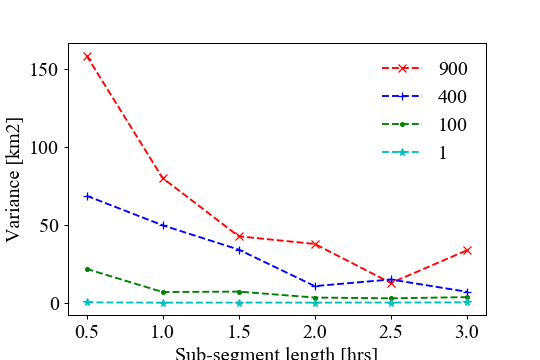

[900. 900. 900. 900. 900. 900. 900. 900. 900. 900.]
[400. 400. 400. 400. 400. 400. 400. 400. 400. 400.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

y = 6
    
plt.figure()
x = len(_ncov)-1 
plt.plot(SSGLEN[:,x][0:y], KSPVARX[:,x][0:y]*1e-6, 'rx--')
print(NCOV[:,x])

x = len(_ncov)-5 
plt.plot(SSGLEN[:,x][0:y], KSPVARX[:,x][0:y]*1e-6, 'b+--')
print(NCOV[:,x])

x = len(_ncov)-9
plt.plot(SSGLEN[:,x][0:y], KSPVARX[:,x][0:y]*1e-6, 'g.--')
print(NCOV[:,x])

x = len(_ncov)-13
plt.plot(SSGLEN[:,x][0:y], KSPVARX[:,x][0:y]*1e-6, 'c*--')
print(NCOV[:,x])

plt.xlabel('Sub-segment length [hrs]')
plt.ylabel('Variance [km2]')



plt.legend(['900', '400', '100', '1'], frameon = False)

plt.show();
#plt.savefig("error_vs_sslen.svg")

<IPython.core.display.Javascript object>


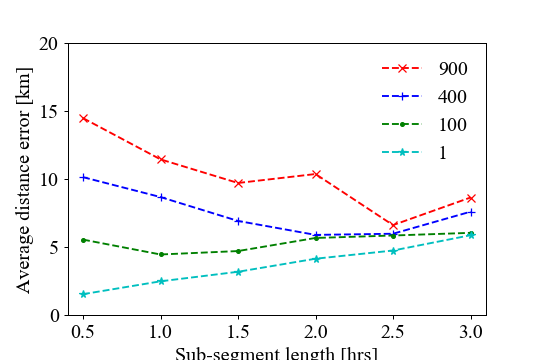

[900. 900. 900. 900. 900. 900. 900. 900. 900. 900.]
[400. 400. 400. 400. 400. 400. 400. 400. 400. 400.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [7]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


y = 6
    
plt.figure()
x = len(_ncov)-1 
plt.plot(SSGLEN[:,x][0:y], ERROR[:,x][0:y], 'rx--')
print(NCOV[:,x])

x = len(_ncov)-5 
plt.plot(SSGLEN[:,x][0:y], ERROR[:,x][0:y], 'b+--')
print(NCOV[:,x])

x = len(_ncov)-9
plt.plot(SSGLEN[:,x][0:y], ERROR[:,x][0:y], 'g.--')
print(NCOV[:,x])

x = len(_ncov)-13
plt.plot(SSGLEN[:,x][0:y], ERROR[:,x][0:y], 'c*--')
print(NCOV[:,x])

plt.xlabel('Sub-segment length [hrs]')
plt.ylabel('Average distance error [km]')

plt.xlim((0.4,3.1))
plt.ylim((0,20))

plt.legend(['900', '400', '100', '1'], frameon = False)

plt.show();
plt.savefig("error_vs_sslen.svg")

<IPython.core.display.Javascript object>


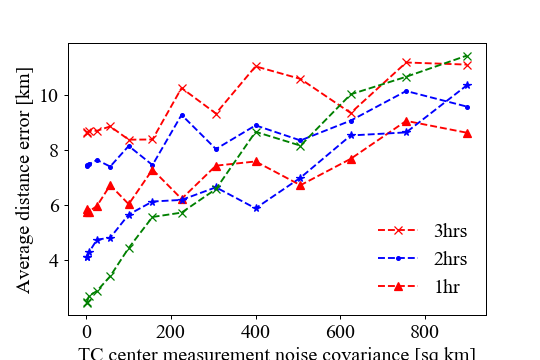

[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [9]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
plt.figure()
'''
x = len(_ssglen)-1
plt.plot(NCOV[x,:], ERROR[x,:], 'rx--')
print(SSGLEN[x,:])

x = len(_ssglen)-3
plt.plot(NCOV[x,:], ERROR[x,:], 'b.--')
print(SSGLEN[x,:])
'''
x = len(_ssglen)-5
plt.plot(NCOV[x,:], ERROR[x,:], 'r^--')
print(SSGLEN[x,:])

x = len(_ssglen)-7 
plt.plot(NCOV[x,:], ERROR[x,:], 'b*--')
print(SSGLEN[x,:])

x = len(_ssglen)-9
plt.plot(NCOV[x,:], ERROR[x,:], 'gx--')
print(SSGLEN[x,:])

plt.xlabel('TC center measurement noise covariance [sq km]')
plt.ylabel('Average distance error [km]')

#plt.xlim((0,400))
#plt.ylim((2,9))
plt.legend(['3hrs','2hrs', '1hr'], frameon = False)
plt.show();
#plt.savefig("error_vs_noise.svg")

In [39]:
_ssglen

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])